# person关键点检测预测-Python API



## 导入工具包

In [1]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [2]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [36]:
img_path = 'data/multi-person.jpg'

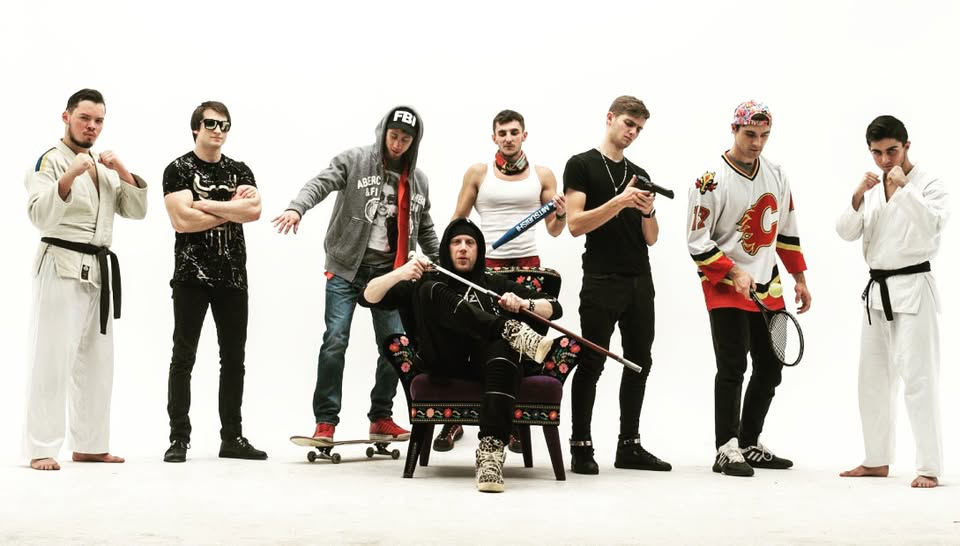

In [37]:
Image.open(img_path)

## 准备好的模型文件

In [5]:
## 目标检测模型

# Faster R CNN 需重新训练
# data/faster_r_cnn_triangle.py
# checkpoint/faster_r_cnn_triangle_epoch_50_202305120846-76d9dde3.pth

# RTMDet-nano
# mmdetection/work_dirs/rtmdet_nano_320-8xb32_coco-person/rtmdet_nano_320-8xb32_coco-person.py
# mmpose/demo/mmdetection_cfg/rtmdet_nano_320-8xb32_coco-person.py
# mmdetection/checkpoint/rtmdet_nano_320-8xb32_coco-person_epoch_300-b4f1f380.pth

## 关键点检测模型

# mmpose/work_dirs/rtmpose-t_8xb256-420e_coco-256x192/rtmpose-t_8xb256-420e_coco-256x192.py
# mmpose/configs/body_2d_keypoint/rtmpose/coco/rtmpose-t_8xb256-420e_coco-256x192.py
# mmpose/checkpoint/rtmpose-t_8xb256-420e_coco-256x192-100-97c86b4e_20241204.pth

## 构建目标检测模型（任选一个运行）

In [6]:
# Faster R CNN 目标检测
# detector = init_detector(
#     'mmpose/demo/mmdetection_cfg/faster_r_cnn_ding_copy.py',
#     '这里放自己训练的R cnn模型，在mmdetetcion/work_dirs/faster_r_cnn_ding_copy 里面',
#     device=device
# )

In [7]:
# RTMDet 目标检测
detector = init_detector(
    'mmdetection/work_dirs/rtmdet_nano_320-8xb32_coco-person/rtmdet_nano_320-8xb32_coco-person.py',
    'mmdetection/checkpoint/rtmdet_nano_320-8xb32_coco-person_epoch_300-b4f1f380.pth',
    device=device
)

Loads checkpoint by local backend from path: mmdetection/checkpoint/rtmdet_nano_320-8xb32_coco-person_epoch_300-b4f1f380.pth


## 构建关键点检测模型

In [8]:
# pose_estimator = init_pose_estimator(
#     'mmpose/work_dirs/rtmpose-t_8xb256-420e_coco-256x192/rtmpose-t_8xb256-420e_coco-256x192.py',
#     'mmpose/checkpoint/rtmpose-t_8xb256-420e_coco-256x192-100-97c86b4e_20241204.pth',
#     device=device,
#     cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
# )
pose_estimator = init_pose_estimator(
    'mmpose/configs/wholebody_2d_keypoint/topdown_heatmap/coco-wholebody/td-hm_hrnet-w48_dark-8xb32-210e_coco-wholebody-384x288.py',
    'mmpose/checkpoint/wholebody_2d_keypoint/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)


Loads checkpoint by local backend from path: mmpose/checkpoint/wholebody_2d_keypoint/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth


/home/dshengq/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmpose/datasets/datasets/utils.py:102: UserWarning: The metainfo config file "configs/_base_/datasets/coco_wholebody.py" does not exist. A matched config file "/home/dshengq/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmpose/.mim/configs/_base_/datasets/coco_wholebody.py" will be used instead.
  warnings.warn(


## 预测-目标检测

In [9]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

12/05 14:15:32 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [10]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

/home/dshengq/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
detect_result.keys()

['ignored_instances', 'pred_instances', 'gt_instances']

In [12]:
# 预测类别
detect_result.pred_instances.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')

In [13]:
# 置信度
detect_result.pred_instances.scores

tensor([0.6668, 0.6185, 0.6011, 0.5486, 0.5194, 0.4257, 0.3580, 0.3533, 0.2920,
        0.2304, 0.2300, 0.2002, 0.1916, 0.1843, 0.1786, 0.1784, 0.1779, 0.1759,
        0.1727, 0.1721, 0.1660, 0.1619, 0.1511, 0.1461, 0.1436, 0.1412, 0.1395,
        0.1390, 0.1360, 0.1354, 0.1337, 0.1242, 0.1223, 0.1222, 0.1205, 0.1193,
        0.1082, 0.1062, 0.1042, 0.1034, 0.1022, 0.1013, 0.1008, 0.0988, 0.0965,
        0.0947, 0.0932, 0.0918, 0.0909, 0.0886, 0.0882, 0.0881, 0.0877, 0.0876,
        0.0862, 0.0861, 0.0860, 0.0857, 0.0855, 0.0822, 0.0816, 0.0810, 0.0807,
        0.0805, 0.0801, 0.0791, 0.0790, 0.0789, 0.0775, 0.0770, 0.0768, 0.0765,
        0.0759, 0.0747, 0.0747, 0.0730, 0.0708, 0.0706, 0.0699, 0.0697, 0.0675,
        0.0672, 0.0668, 0.0668, 0.0668, 0.0663, 0.0650, 0.0648, 0.0642, 0.0637,
        0.0634, 0.0625, 0.0625, 0.0611, 0.0609, 0.0607, 0.0600, 0.0599, 0.0589,
        0.0578], device='cuda:0')

In [14]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [15]:
# 置信度阈值
CONF_THRES = 0.5

In [16]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')

In [17]:
bboxes

array([[693,  97, 806, 478],
       [157,  98, 262, 473],
       [ 22,  84, 149, 475],
       [551,  95, 674, 481],
       [845, 112, 953, 485]])

## 预测-关键点

In [18]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

12/05 14:15:35 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".
tag-2
preds: [<InstanceData(

    META INFORMATION

    DATA FIELDS
    keypoint_scores: array([[0.98298806, 1.0002209 , 0.9930297 , 0.9110755 , 0.96141505,
                0.9296006 , 0.89641154, 0.9171416 , 0.95929205, 0.9640025 ,
                0.992899  , 0.8042823 , 0.8115469 , 0.92125154, 0.92814636,
                0.8816818 , 0.90751195, 0.81391   , 0.7868429 , 0.8081547 ,
                0.75224686, 0.7490665 , 0.85748076, 0.9922925 , 1.003948  ,
                0.9668369 , 0.9682192 , 0.9583882 , 0.9631697 , 0.9599062 ,
                0.9504065 , 0.96306294, 0.9681747 , 0.9554863 , 0.9839901 ,
                0.99171436, 0.98563945, 0.97997665, 0.99243695, 1.0009062 ,
                0.9935031 , 0.9945098 , 0.993731  , 0.99778336, 0.9952593 ,
                0.991959  , 0.99828035, 0.9886795 , 0.97368777, 0.988582

In [19]:
len(pose_results)

5

In [20]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [21]:
data_samples.keys()

['_pred_heatmaps', 'pred_instances', 'pred_fields', 'gt_instances']

## 预测结果-关键点坐标

In [22]:
keypoints = data_samples.pred_instances.keypoints.astype('int')

In [23]:
keypoints

array([[[758, 142],
        [764, 134],
        [750, 133],
        ...,
        [740, 291],
        [742, 291],
        [743, 291]],

       [[218, 129],
        [223, 124],
        [211, 122],
        ...,
        [247, 195],
        [247, 195],
        [247, 196]],

       [[ 92, 126],
        [ 98, 120],
        [ 84, 117],
        ...,
        [ 88, 165],
        [ 89, 167],
        [ 89, 168]],

       [[634, 132],
        [639, 128],
        [629, 123],
        ...,
        [639, 206],
        [641, 206],
        [643, 206]],

       [[885, 160],
        [893, 150],
        [877, 152],
        ...,
        [869, 183],
        [872, 185],
        [873, 186]]])

In [24]:
keypoints.shape

(5, 133, 2)

In [25]:
# 索引为 0 的框，每个关键点的坐标
keypoints[0,:,:]

array([[758, 142],
       [764, 134],
       [750, 133],
       [767, 136],
       [734, 130],
       [777, 176],
       [712, 177],
       [788, 234],
       [698, 242],
       [800, 280],
       [735, 272],
       [764, 283],
       [726, 284],
       [770, 368],
       [733, 368],
       [748, 445],
       [726, 452],
       [782, 458],
       [782, 458],
       [744, 451],
       [743, 467],
       [742, 467],
       [722, 459],
       [736, 129],
       [735, 132],
       [736, 137],
       [736, 142],
       [737, 146],
       [739, 150],
       [742, 153],
       [745, 156],
       [749, 157],
       [753, 158],
       [757, 156],
       [760, 153],
       [762, 149],
       [764, 146],
       [766, 142],
       [767, 137],
       [768, 134],
       [745, 130],
       [748, 130],
       [750, 130],
       [753, 130],
       [755, 131],
       [761, 132],
       [763, 131],
       [765, 131],
       [767, 132],
       [768, 132],
       [758, 134],
       [758, 137],
       [758,

## 预测结果-关键点热力图

In [26]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(133, 546, 960)

In [27]:
kpt_idx = 1
heatmap = data_samples.pred_fields.heatmaps[kpt_idx,:,:]

In [28]:
heatmap.shape

(546, 960)

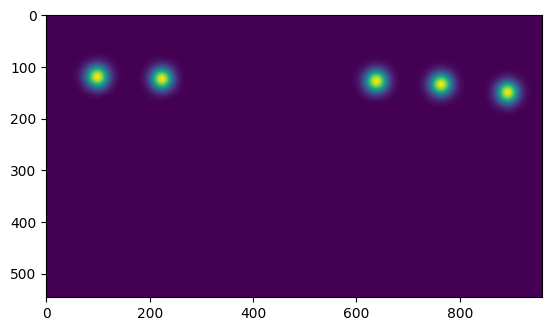

In [29]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## MMPose官方可视化工具`visualizer`

In [30]:
img_path = 'mmpose/data/test/multi-person.jpg'

In [31]:
# 半径
pose_estimator.cfg.visualizer.radius = 3

# 线宽
pose_estimator.cfg.visualizer.line_width = 2
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

/home/dshengq/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [32]:
# 元数据
pose_estimator.dataset_meta

{'dataset_name': 'coco_wholebody',
 'num_keypoints': 133,
 'keypoint_id2name': {0: 'nose',
  1: 'left_eye',
  2: 'right_eye',
  3: 'left_ear',
  4: 'right_ear',
  5: 'left_shoulder',
  6: 'right_shoulder',
  7: 'left_elbow',
  8: 'right_elbow',
  9: 'left_wrist',
  10: 'right_wrist',
  11: 'left_hip',
  12: 'right_hip',
  13: 'left_knee',
  14: 'right_knee',
  15: 'left_ankle',
  16: 'right_ankle',
  17: 'left_big_toe',
  18: 'left_small_toe',
  19: 'left_heel',
  20: 'right_big_toe',
  21: 'right_small_toe',
  22: 'right_heel',
  23: 'face-0',
  24: 'face-1',
  25: 'face-2',
  26: 'face-3',
  27: 'face-4',
  28: 'face-5',
  29: 'face-6',
  30: 'face-7',
  31: 'face-8',
  32: 'face-9',
  33: 'face-10',
  34: 'face-11',
  35: 'face-12',
  36: 'face-13',
  37: 'face-14',
  38: 'face-15',
  39: 'face-16',
  40: 'face-17',
  41: 'face-18',
  42: 'face-19',
  43: 'face-20',
  44: 'face-21',
  45: 'face-22',
  46: 'face-23',
  47: 'face-24',
  48: 'face-25',
  49: 'face-26',
  50: 'face-27',

In [33]:
import mmcv

img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

# 绘制关键点时调整半径
# visualizer.draw_keypoints(keypoints, keypoint_radius=5)  # 将半径设置为5（根据需要调整）

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show=True,
            show_kpt_idx=False,
            wait_time=0,
            out_file='outputs/G3_visualizer.jpg',
            kpt_thr=0.3
)

In [34]:
img_output.shape

(1092, 960, 3)

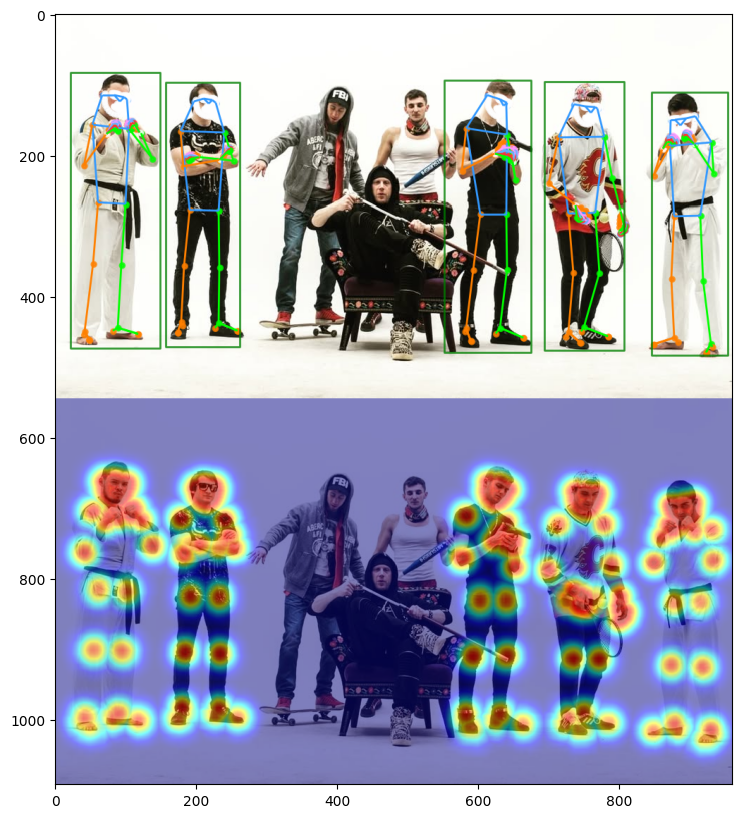

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(img_output)
plt.show()